In [47]:
import json
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import shap
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch.nn.functional as F
import time
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from matplotlib.patches import Ellipse
from lime import lime_image
from skimage.segmentation import mark_boundaries
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
import torch
from skimage.color import label2rgb
from skimage.segmentation import slic

### **Grad-CAM setup**

In [48]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.eval()
target_layers = [model.layer4[-1]]

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img_path = "../data/figure_data/dog_and_cat.jpg"
original_image = Image.open(img_path).convert("RGB")
rgb_img_resized = original_image.resize((224, 224))

input_tensor = transform(rgb_img_resized).unsqueeze(0)

rgb_img = np.array(rgb_img_resized).astype(np.float32) / 255.0

In [50]:
with torch.no_grad():
    outputs = model(input_tensor)
    probabilities = F.softmax(outputs, dim=1)
    predicted_class = outputs.argmax().item()
    confidence = probabilities[0, predicted_class].item()
    print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")

targets = [ClassifierOutputTarget(predicted_class)]

Predicted Class: 156, Confidence: 0.07


In [51]:
t1_grad = time.time()
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
end_grad = time.time()
duration_grad = end_grad - t1_grad
print(duration_grad)

0.1168670654296875


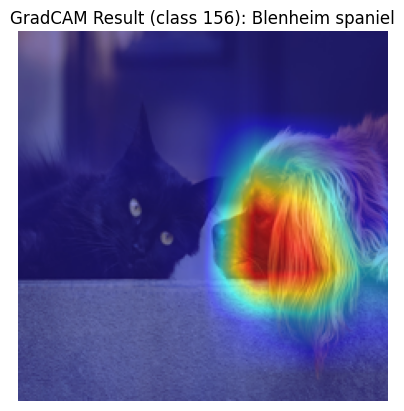

In [52]:
plt.imshow(visualization)
plt.title(f"GradCAM Result (class {predicted_class}): Blenheim spaniel")
plt.axis('off')
plt.savefig("../outputs/gradcam_dog_cat.pdf")
plt.show()

1st run: 0.12482690811157227  
2nd run: 0.14626407623291016  
3rd run: 0.1168670654296875

In [62]:
sum_grad = np.mean([0.12482690811157227, 0.14626407623291016, 0.1168670654296875])
sum_grad

0.1293193499247233

### **LIME setup**

In [53]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img_path = "../data/figure_data/dog_and_cat.jpg"
img = Image.open(img_path).convert('RGB')
input_tensor = preprocess(img).unsqueeze(0)

def custom_segmentation(image):
    return slic(image, n_segments=50, compactness=10, sigma=1)

In [54]:
def batch_predict(images):
    model.eval()
    batch = torch.stack([preprocess(Image.fromarray(img)) for img in images], dim=0)
    with torch.no_grad():
        outputs = model(batch)
        return outputs.softmax(1).numpy()
    
input_tensor = preprocess(img).unsqueeze(0)
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = output.argmax(dim=1).item()

In [56]:
t1_lime = time.time()
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    np.array(img),
    batch_predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=custom_segmentation
)
end_lime = time.time()
duration_lime = end_lime - t1_lime
print(duration_lime)

100%|██████████| 1000/1000 [00:58<00:00, 17.08it/s]

59.10060381889343


1st run: 61.32227873802185  
2nd run: 60.01610803604126  
3rd run: 59.10060381889343

In [61]:
sum_lime = np.mean([61.32227873802185, 60.01610803604126 , 59.10060381889343])
sum_lime

60.14633019765218

In [ ]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=3,
    hide_rest=True
)

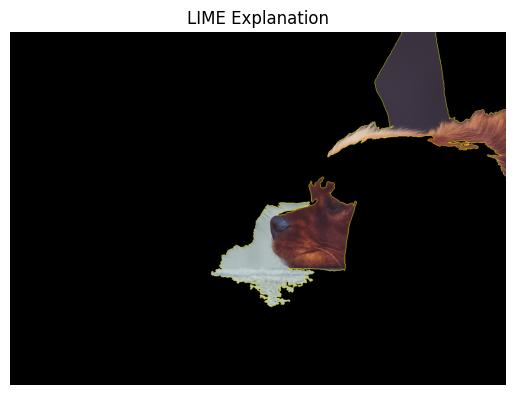

In [ ]:
plt.imshow(mark_boundaries(temp / 255.0, mask, color=(1, 1, 0)))
plt.title(f"LIME Explanation")
plt.axis('off')
plt.savefig("../outputs/lime_hide_rest.pdf")
plt.show()

### **SHAP setup**

In [57]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
X, y = shap.datasets.imagenet50()

In [58]:
# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
# print("Number of ImageNet classes:", len(class_names))
# print("Class names:", class_names)

In [ ]:
t1_shap = time.time()
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    tmp_tensor = torch.from_numpy(tmp).permute(0, 3, 1, 2).float()
    return model(tmp_tensor)


masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)

explainer_blur = shap.Explainer(f, masker_blur, output_names=class_names)

shap_values_fine = explainer_blur(X[1:2], max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
end_shap = time.time()
duration_shap = end_shap - t1_shap
print(duration_shap)

PartitionExplainer explainer: 2it [01:38, 98.43s/it]               

98.81128883361816


1st run: 98.82230305671692  
2nd run: 97.7043809890747  
3rd run: 98.81128883361816

In [60]:
sum_shap = np.mean([98.82230305671692, 97.7043809890747, 98.81128883361816])
sum_shap

98.44599095980327

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


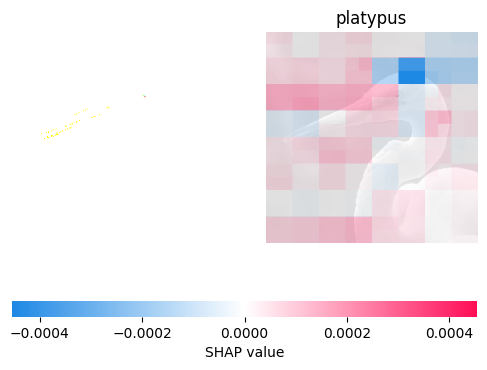

In [ ]:
# output with shap values
shap.image_plot(shap_values_fine)

### **Compare**

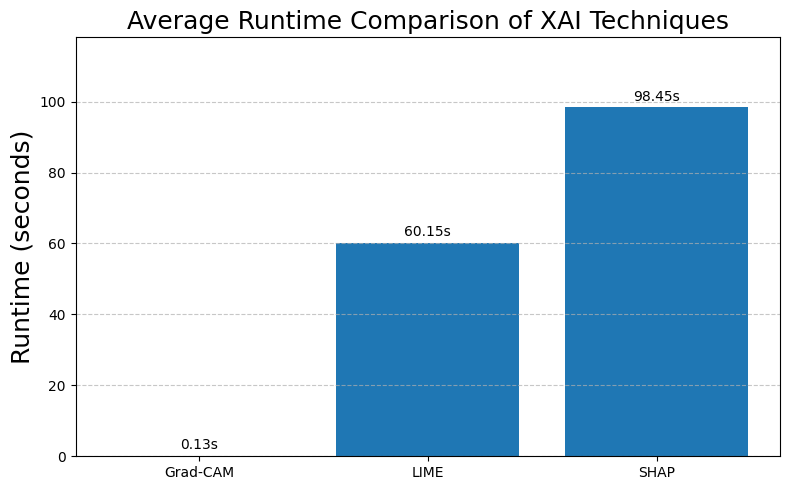

In [71]:
runtimes = {
    'Grad-CAM': sum_grad,    
    'LIME': sum_lime, 
    'SHAP': sum_shap 
}

methods = list(runtimes.keys())
times = list(runtimes.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(methods, times)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}s', ha='center', va='bottom')

plt.ylabel('Runtime (seconds)', fontsize = 18)
plt.title('Average Runtime Comparison of XAI Techniques', fontsize = 18)
plt.ylim(0, max(times) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("..//outputs/compute_compare.pdf")
plt.show()